## ACHIVED RESULTS:

**test accuracy of 95.87%**

**Precision: 0.7809**

**Recall: 0.7652**

**F1 Score: 0.7729**

## **informations**



**Dear Teams,**

This document provides a template for your work to create an LSTM based model that serves as a backend for an IDS system that filters malicious messages detected in the internal CAN network of a car. You should create a model that does binary classification on CAN message frames.

0 - non-malicious

1 - malicious/ (in this case) fuzzing messages


You should be able to solve the task by only editing 'TODO' parts. Please don't make any changes to the remaining code snippets.

**Solutions**

If you are ready with your solutions please send the models, as well as the finalised jupiter notebooks with outputs and the documentations to our contact email address.

**Contact us**

If you may have any questions send us an email: msgplaut.hu@gmail.com

**Useful links**

LSTM-Based Intrusion Detection System for In-Vehicle Can Bus Communications: https://ieeexplore.ieee.org/abstract/document/9216166\

A curated CAN dataset for automotive intrusion detection: https://www.sciencedirect.com/science/article/pii/S0167404824000786#se0310
(This is the source of the datasets provided by us)

Multivariate Time Series Classification Tutorial with LSTM in PyTorch, PyTorch Lightning and Python: https://www.youtube.com/watch?v=PCgrgHgy26c
(Watch out! In your solution you should be using tensorflow with keras)

How LSTM Networks Work?: https://www.youtube.com/watch?v=guqgmVqcy2c

## **Importing libraries**

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Nadam
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# To include learning rate
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam


## **Loading the dataset**

In [2]:
# Load dataset
dff = pd.read_csv('fuzzing-1-forester.csv')
dfi = pd.read_csv('fuzzing-1-impala.csv')
dfs = pd.read_csv('fuzzing-1-silverado.csv')

dff.shape

(660170, 4)

In [3]:
df = pd.concat([dff, dfi, dfs])

## **Data Preprocessing:**

In [4]:
# Define a function that handles the empty string case
def safe_convert_hex(x):
    if pd.isna(x) or x == '' or isinstance(x, float):  # Handle missing or float values
        return 0  # Return 0 for missing/invalid values
    try:
        return int(str(x), 16)
    except ValueError:
        print(f"Error converting {x} to int")
        return 0  # Return the placeholder value for any other conversion errors


In [5]:
# Function to split the data field into bytes
def split_data_field(data_field):
    if pd.isna(data_field) or isinstance(data_field, float):  # Handle missing/invalid values
        return [0] * 8

    data_field = str(data_field).zfill(16)
    return [safe_convert_hex(data_field[i:i+2]) for i in range(0, len(data_field), 2)]


# Convert timestamp to float
df['timestamp'] = df['timestamp'].astype(float)

# Convert arbitration_id and data_field
df['arbitration_id'] = df['arbitration_id'].apply(safe_convert_hex)
df['data_field'] = df['data_field'].apply(lambda x: split_data_field(x))

# Split `data_field` into individual byte columns
df[['D0', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7']] = pd.DataFrame(df['data_field'].tolist(), index=df.index)

# Ensure you're using all 10 features (timestamp, arbitration_id, and D0-D7)
X = df[['timestamp', 'arbitration_id', 'D0', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7']].values
y = df['attack'].values

print(f"Number of records: {len(X)}")
print(f"Shape of X (features): {X.shape}")

Number of records: 1859362
Shape of X (features): (1859362, 10)


In [ ]:
print(X[:5])

[[1.6725312e+09 3.3800000e+02 2.4900000e+02 1.6400000e+02 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 1.6000000e+01 1.4000000e+02]
 [1.6725312e+09 3.5600000e+02 4.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 4.0000000e+00]
 [1.6725312e+09 3.2800000e+02 1.1000000e+01 2.5000000e+01 0.0000000e+00
  1.2800000e+02 6.5000000e+01 0.0000000e+00 1.7000000e+01 5.0000000e+00]
 [1.6725312e+09 3.2900000e+02 1.2400000e+02 1.0000000e+00 6.3000000e+01
  1.2100000e+02 1.6900000e+02 2.0000000e+01 0.0000000e+00 0.0000000e+00]
 [1.6725312e+09 3.4200000e+02 1.0000000e+00 1.2800000e+02 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 1.5000000e+01]]


**Normalizing features**

In [6]:
# Normalize features with scaler
# Initialize the scaler
scaler = StandardScaler()

# Apply the scaler to the features
X_scaled = scaler.fit_transform(X)

In [ ]:
print(X_scaled[:5])

[[-0.35304924  3.00764396]
 [-0.2997958  -0.53477834]
 [-0.38263448 -0.43242181]
 [-0.37967596  1.19583094]
 [-0.34121514 -0.57083124]]


**Applying SMOTE to create balanced dataset**

In [7]:
# Apply SMOTE to create balanced dataset
smote = SMOTE(sampling_strategy='auto', random_state=42)

X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

In [ ]:
print(f"Original dataset shape: {X_scaled.shape}")
print(f"Resampled dataset shape: {X_resampled.shape}")

**Sequence Creation**

In [8]:
# Define the sequence length
sequence_length = 10

# Create sequences
def create_sequences(X, y, seq_length):
    X_seq = []
    y_seq = []

    for i in range(len(X) - seq_length):
        X_seq.append(X[i:i+seq_length])
        y_seq.append(y[i + seq_length - 1])

    X_seq = np.array(X_seq)
    y_seq = np.array(y_seq)

    return X_seq, y_seq


**Creating sequences after resampling**


In [9]:
# Create sequences after resampling
X_seq, y_seq = create_sequences(X_resampled, y_resampled, sequence_length)

In [ ]:
# Print the shape of the sequences to check if they are correct
print(f"Shape of X_seq: {X_seq.shape}")
print(f"Shape of y_seq: {y_seq.shape}")

Shape of X_seq: (3471596, 20, 2)
Shape of y_seq: (3471596,)


**Spliting the data into training and testing sets**

In [10]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)
# Print the size of the training and testing sets
print(f'Training set size: {len(X_train)}')
print(f'Test set size: {len(X_test)}')


Training set size: 2777284
Test set size: 694322


In [11]:
# Define the ModelCheckpoint callback
checkpoint_callback = ModelCheckpoint(
    filepath='best_model.keras', # Path where the model will be saved
    monitor='val_loss',       # Quantity to monitor
    save_best_only=True,      # Save only the best model
    verbose=1                 # Verbosity mode (1 = progress bar)
)

# Define the EarlyStopping callback
early_stopping_callback = EarlyStopping(
    monitor='val_loss',       # Quantity to monitor
    patience=5,              # Number of epochs with no improvement after which training will be stopped
    verbose=1                 # Verbosity mode
)

## **Defining a deeper LSTM model**

In [ ]:
# Define a deep LSTM model with stacked layers
model = Sequential()

# First LSTM layer with more units, return sequences for stacking layers
model.add(LSTM(units=64, return_sequences=True, input_shape=(sequence_length, 10)))  # 10 features (timestamp + arbitration_id + D0-D7)
model.add(BatchNormalization())  # Normalize the output of the LSTM layer
model.add(Dropout(0.2))  # Dropout to avoid overfitting

# Second LSTM layer
model.add(LSTM(units=32, return_sequences=False))  # Output only the final hidden state
model.add(BatchNormalization())  # Normalize
model.add(Dropout(0.2))  # Dropout

# Fully connected layer before the output
model.add(Dense(units=16, activation='relu'))  # Dense layer to learn more complex patterns
model.add(Dropout(0.2))  # Dropout

# Output layer for binary classification
model.add(Dense(units=1, activation='sigmoid'))  # Binary output


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


**Compiling the model**

In [ ]:
# Compile the model
model.compile(optimizer=Nadam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 10, 64)              │          19,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 10, 64)              │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 10, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 32,545 (127.13 KB)

 Trainable params: 32,353 (126.38 KB)

 Non-trainable params: 192 (768.00 B)

**Visualizing the model**

In [ ]:
!pip3 install keras-visualizer
from keras_visualizer import visualizer
import matplotlib.image as mpimg
visualizer(model, file_format='png', view=True)

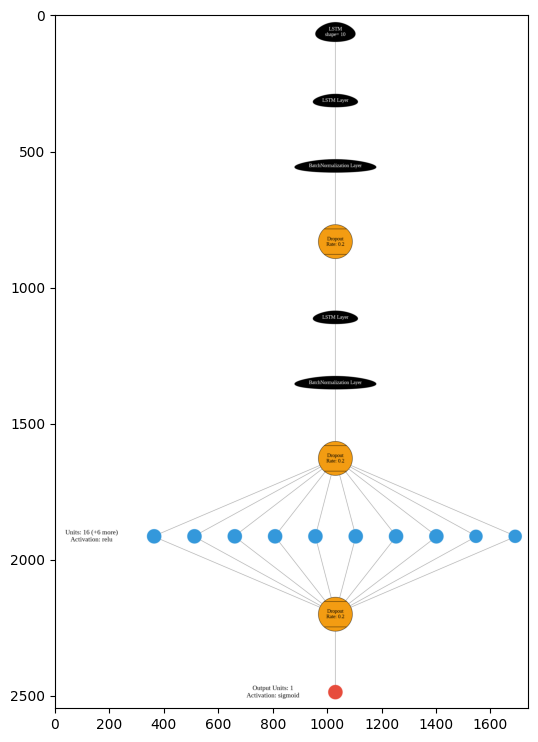

In [ ]:
%matplotlib inline
img = mpimg.imread('graph.png')
fig = plt.figure(figsize=[20,9])
plt.imshow(img)
plt.show()

## **Training the model**

In [ ]:
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")


Shape of X_train: (2777284, 10, 10)
Shape of X_test: (694322, 10, 10)


In [ ]:
# Train the model

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=64,
    validation_split=0.2,
    callbacks=[checkpoint_callback, early_stopping_callback],
    verbose=1                   # 1 for progress bar, 2 for just line per epoch
)


Epoch 1/20
43396/43396 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9671 - loss: 0.0922
Epoch 1: val_loss improved from inf to 0.03309, saving model to best_model.keras
43396/43396 ━━━━━━━━━━━━━━━━━━━━ 488s 11ms/step - accuracy: 0.9671 - loss: 0.0922 - val_accuracy: 0.9882 - val_loss: 0.0331
Epoch 2/20
43395/43396 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9865 - loss: 0.0392
Epoch 2: val_loss improved from 0.03309 to 0.02615, saving model to best_model.keras
43396/43396 ━━━━━━━━━━━━━━━━━━━━ 500s 11ms/step - accuracy: 0.9865 - loss: 0.0392 - val_accuracy: 0.9904 - val_loss: 0.0261
Epoch 3/20
43392/43396 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9891 - loss: 0.0309
Epoch 3: val_loss improved from 0.02615 to 0.02217, saving model to best_model.keras
43396/43396 ━━━━━━━━━━━━━━━━━━━━ 513s 11ms/step - accuracy: 0.9891 - loss: 0.0309 - val_accuracy: 0.9916 - val_loss: 0.0222
Epoch 4/20
23629/43396 ━━━━━━━━━━━━━━━━━━━━ 3:18 10ms/step - accuracy: 0.9903 - loss: 0.0268

## **Evaluation of the model Accuracy (Accuracy)**

In [ ]:
   # Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy:.4f}')


21698/21698 ━━━━━━━━━━━━━━━━━━━━ 104s 5ms/step - accuracy: 0.9922 - loss: 0.0213
Test Accuracy: 0.9922


**Making a predection on the test dataset**

In [ ]:
# Make predictions
y_pred = (model.predict(X_test) > 0.5).astype("int32")
print(y_pred.shape)

21698/21698 ━━━━━━━━━━━━━━━━━━━━ 102s 5ms/step
(694322, 1)


**Computing the matrics for the evaluation**

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

# Compute metrics
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Precision
print(f'Precision: {precision:.4f}')

# Recall
print(f'Recall: {recall:.4f}')

# F1 Score
print(f'F1 Score: {f1:.4f}')

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Attack'], yticklabels=['Normal', 'Attack'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


NameError: name 'y_pred' is not defined

In [ ]:
# Print the classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99    347543
           1       1.00      0.99      0.99    346779

    accuracy                           0.99    694322
   macro avg       0.99      0.99      0.99    694322
weighted avg       0.99      0.99      0.99    694322



## **Testing on external data**

In [14]:
from tensorflow.keras.models import load_model

# Load the model from the saved file
model = load_model('best_model.keras')


In [12]:
# Load dataset
df_test = pd.read_csv('fuzzing-1-traverse.csv')
df_test.shape

(1235992, 4)

In [13]:
def safe_convert_hex(x):
    """

    Args:
      x:

    Returns:

    """
    if pd.isna(x) or x == '' or isinstance(x, float):  # Handle missing or float values
        return 0  # Return 0 for missing/invalid values
    try:
        return int(str(x), 16)  # Convert hex to int
    except ValueError:
        print(f"Error converting {x} to int")
        return 0  # Return 0 for invalid hex values

# Function to split the data field into bytes
def split_data_field(data_field):
    # Ensure each value is processed individually
    if pd.isna(data_field) or isinstance(data_field, float):  # Handle missing/invalid values
        return [0] * 8  # Return a list of 8 zeroes if the data field is missing or invalid

    # Ensure it's a string and pad to 16 characters (8 bytes)
    data_field = str(data_field).zfill(16)

    # Split the data field into 8 bytes (chunks of 2 hex characters) and convert to integers
    return [safe_convert_hex(data_field[i:i+2]) for i in range(0, len(data_field), 2)]

# Convert timestamp to float
df_test['timestamp'] = df_test['timestamp'].astype(float)

# Convert arbitration_id and data_field
df_test['arbitration_id'] = df_test['arbitration_id'].apply(safe_convert_hex)
df_test['data_field'] = df_test['data_field'].apply(lambda x: split_data_field(x))

# Now split `data_field` into individual byte columns
df_test[['D0', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7']] = pd.DataFrame(df_test['data_field'].tolist(), index=df_test.index)

# Ensure you're using all 11 features (timestamp, arbitration_id, and D0-D7)
X_test = df_test[['timestamp', 'arbitration_id', 'D0', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7']].values
y_test = df_test['attack'].values  # Binary labels: 0 (benign), 1 (attack)

# Check the shape of the transformed data
(X_test.shape, len(y_test))

((1235992, 10), 1235992)

In [15]:
# Initialize and fit the scaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_test)

# Print first few rows of the scaled data to check
print(X_scaled[:5])

[[-1.57235125 -0.90224797 -0.60505698 -0.71713053 -0.6004858  -0.67023164
  -0.55758975 -0.75961821 -0.68311846 -0.86204638]
 [-1.57235114 -0.27714167 -0.49489533 -0.50434414 -0.49458006  2.07813908
  -0.45489356  2.16160095 -0.68311846 -0.86204638]
 [-1.57235111  0.01040723 -0.60505698 -0.71713053 -0.6004858  -0.78718359
  -0.55758975 -0.75961821 -0.5832936  -0.86204638]
 [-1.57235108  0.0166583  -0.60505698 -0.71713053 -0.6004858  -0.78718359
  -0.55758975 -0.75961821 -0.68311846 -0.86204638]
 [-1.57233826 -0.09586084 -0.60505698 -0.71713053 -0.6004858  -0.78718359
  -0.55758975 -0.56884472 -0.68311846 -0.86204638]]


In [16]:
X_sequence, y_sequence = create_sequences(X_scaled, y_test, 10)

In [17]:
y_predicted = (model.predict(X_sequence) > 0.5).astype("int32")
print(y_predicted.shape)

38625/38625 ━━━━━━━━━━━━━━━━━━━━ 89s 2ms/step
(1235982, 1)


In [18]:
loss, accuracy = model.evaluate(X_sequence, y_sequence)
print(f'Test Accuracy: {accuracy:.4f}')

38625/38625 ━━━━━━━━━━━━━━━━━━━━ 117s 3ms/step - accuracy: 0.9232 - loss: 0.2560
Test Accuracy: 0.9587


Precision: 0.7809
Recall: 0.7652
F1 Score: 0.7729


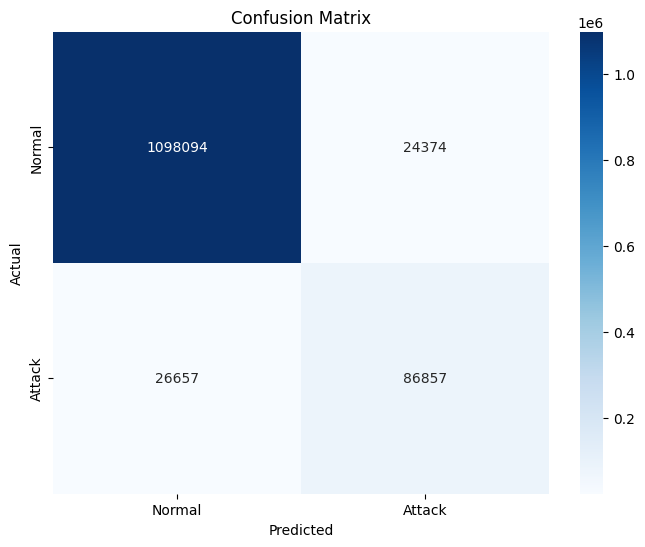

In [19]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

# Compute metrics
precision = precision_score(y_sequence, y_predicted)
recall = recall_score(y_sequence, y_predicted)
f1 = f1_score(y_sequence, y_predicted)

#Precision
print(f'Precision: {precision:.4f}')

#Recall
print(f'Recall: {recall:.4f}')

#F1 Score
print(f'F1 Score: {f1:.4f}')

# Compute the confusion matrix
cm = confusion_matrix(y_sequence, y_predicted)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Attack'], yticklabels=['Normal', 'Attack'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()